In [1]:
using Plots, DataFrames, StatsPlots 
using Random, LinearAlgebra, Statistics, CSV
pyplot()

Plots.PyPlotBackend()

In [2]:
# load data
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
covid = CSV.read("time_series_covid19_deaths_US.csv");

In [3]:
# drop columns we won't use 
cols_to_keep = .![(col in ["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Country_Region", "Lat", "Long_", "Combined_Key"]) for col in names(covid)]
covid_ts = covid[:, cols_to_keep]
state_ts = aggregate(covid_ts, :Province_State, sum)

,Province_State,Population_sum,1/22/20_sum,1/23/20_sum,1/24/20_sum,1/25/20_sum
,String,Int64,Int64,Int64,Int64,Int64
1,Alabama,4903185,0,0,0,0
2,Alaska,731545,0,0,0,0
3,American Samoa,55641,0,0,0,0
4,Arizona,7278717,0,0,0,0
5,Arkansas,3017804,0,0,0,0
6,California,39512223,0,0,0,0
7,Colorado,5758736,0,0,0,0
8,Connecticut,3565287,0,0,0,0
9,Delaware,973764,0,0,0,0


In [4]:
# list of dates for which we have data
dates = map(s->s[1:end-4], vec(convert(Array, names(state_ts)))[4:end])
n = length(dates)

250

In [5]:
# just New York
ny_deaths = diff(vec(convert(Array, state_ts[state_ts.Province_State.=="New York", 3:end])))
df = DataFrame(:date=>dates, :deaths=>ny_deaths)
df[:dateshort] = 1:n # map(s->s[1:end-3], dates)

1:250

In [6]:
# just California
deaths = diff(vec(convert(Array, state_ts[state_ts.Province_State.=="California", 3:end])))
df = DataFrame(:date=>dates, :deaths=>deaths)
df[:dateshort] = 1:n

1:250

In [7]:
function evaluate_error(ypred)
    println("MAE: ", sum(abs.(df[:deaths] - ypred)) / n)
    println("MSE: ", norm(df[:deaths] - ypred) / sqrt(n))
end

evaluate_error (generic function with 1 method)

# predict COVID deaths with a linear model

In [8]:
# how about just using the number of days elapsed?
X = [1:n ones(n)]
y = df[:deaths]
w = X\y

df[!,:pred_linear] = X*w

evaluate_error(df[:pred_linear])

MAE: 30.534502692459085
MSE: 41.73217575069


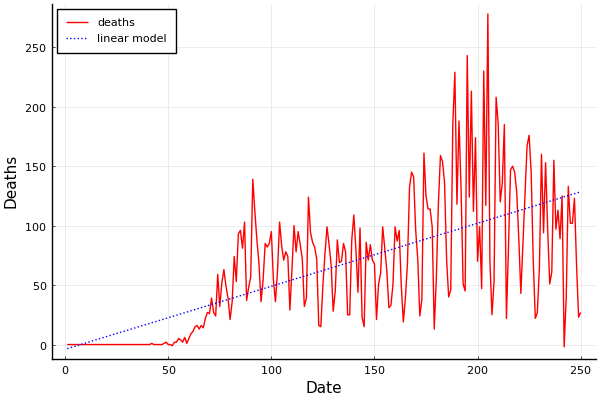

In [9]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
xlabel!("Date")
ylabel!("Deaths")

# Autoregressive models

In [10]:
# how about using the previous level of deaths? (called ``lagged outcome'')
X = [df[1:end-1,:deaths] ones(n-1)]
y = df[2:end,:deaths]
w = X\y
df[!,:pred_ar1] = vcat(df[1,:pred_linear], X*w);

# what if we only know deaths 3 days late?
# X = [df[1:end-3,:deaths] ones(n-3)]
# y = df[4:end,:deaths]
# w = X\y
# df[!,:pred_ar1] = vcat(df[1:3,:pred_linear], X*w);

# also try: 7 day lag

evaluate_error(df[:pred_ar1])

MAE: 30.056559520886598
MSE: 42.61075588718084


In [11]:
w

2-element Array{Float64,1}:
  0.6549421121576041
 21.73483292236317

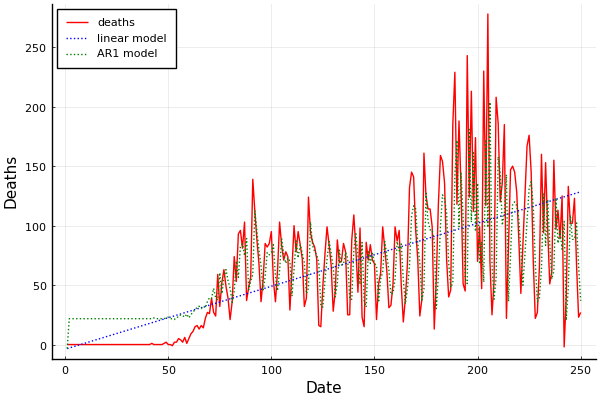

In [12]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
xlabel!("Date")
ylabel!("Deaths")

# Autoregressive with 7 lagged outcomes

In [13]:
n_lags = 8
X = hcat([df[n_lags-i+1:end-i,:deaths] for i=1:n_lags]...)
X = [X ones(n-n_lags)]
y = df[n_lags+1:end,:deaths]
w = X\y
df[!,:pred_arn] = vcat(df[1:n_lags,:pred_linear], X*w);

evaluate_error(df[:pred_arn])

MAE: 19.175768317440124
MSE: 27.668501276955396


In [14]:
w

9-element Array{Float64,1}:
  0.08196449552544076
 -0.05799641805231029
 -0.08846309327320509
  0.13464931638712724
 -0.17409857938982604
  0.36662819109849887
  0.3628416027620701
  0.3153658298024427
  6.002090928820842

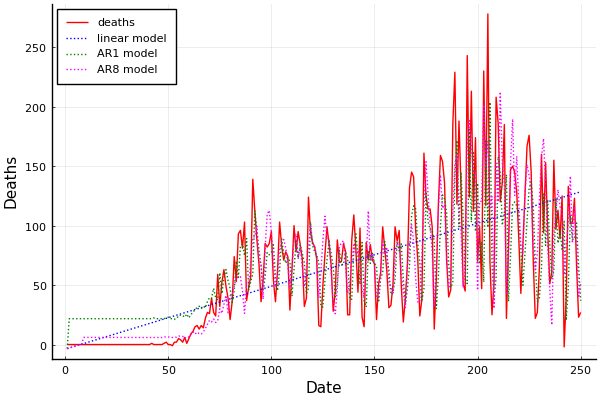

In [15]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_arn, color=:magenta, linestyle=:dot, label="AR$n_lags model")
xlabel!("Date")
ylabel!("Deaths")

# Smoothed models

In [16]:
α = 1
X = zeros(n,n)
for i=1:n
    for j=1:n
        X[i,j] = exp(-(i-j)^2)
    end
end
y = df[:deaths]
w = X\y

df[!,:pred_smooth] = X*w

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth])) / n

7.269090004731163e-15

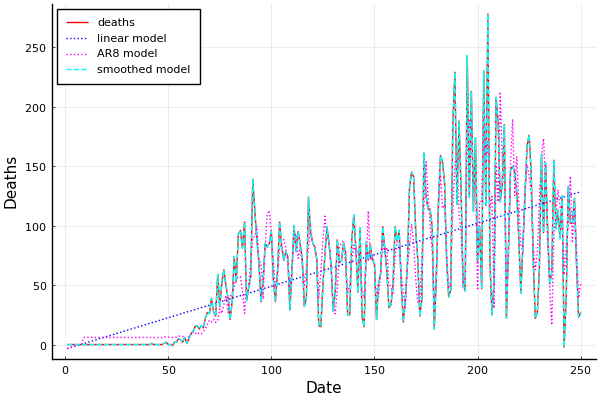

In [17]:
# cyan curve exactly matches red!
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_arn, color=:magenta, linestyle=:dot, label="AR$n_lags model")
plot!(df.dateshort, df.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Date")
ylabel!("Deaths")

# Smoothed models, fewer features

In [18]:
# create 1 new feature for every knot_freq rows
knot_freq = 7
knots = 1:knot_freq:n
X = zeros(n,length(knots))
for i=1:n
    for j = 1:length(knots)
        X[i,j] = exp(-(i-knots[j])^2)
    end
end
# normalize rows
X = X ./ sum(X, dims=2)

X = [X ones(n)]
y = df[:deaths]
w = X\y

df[!,:pred_smooth] = X*w;

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth])) / n

23.96596083541042

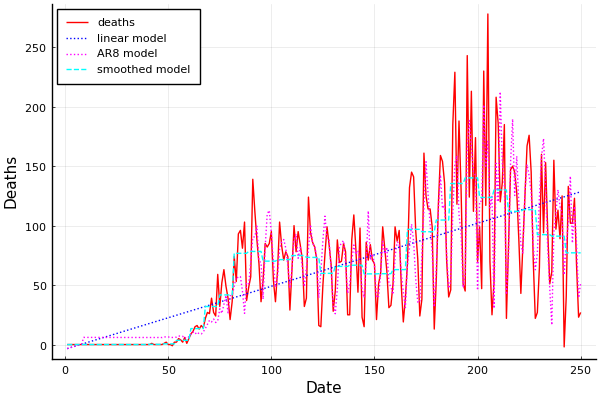

In [19]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_arn, color=:magenta, linestyle=:dot, label="AR$n_lags model")
plot!(df.dateshort, df.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Date")
ylabel!("Deaths")

In [20]:
# AR1 + smoothing 
knot_freq = 7
knots = 1:knot_freq:n
X = zeros(n,length(knots))
for i=1:n
    for j = 1:length(knots)
        X[i,j] = exp(-(i-knots[j])^2)
    end
end
# normalize rows
X = X ./ sum(X, dims=2)

X = [df[1:end-1,:deaths] X[2:end,:] ones(n-1)]
y = df[2:end,:deaths]
w = X\y
df[!,:pred_smooth] = vcat(df[1,:pred_linear], X*w);

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth])) / n

23.238665538772093

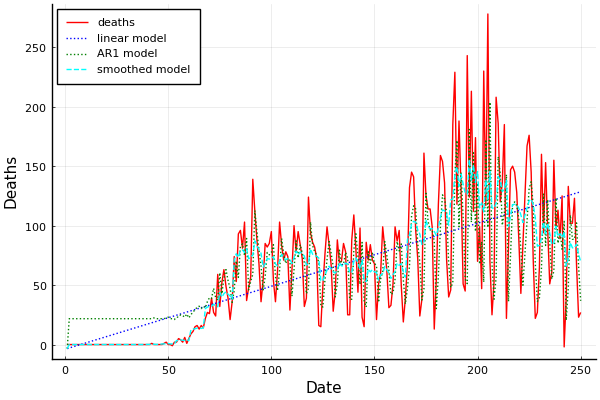

In [21]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Date")
ylabel!("Deaths")

# Smooth + regularize

In [22]:
α =.3
X = zeros(n,n)
for i=1:n
    for j=1:n
        X[i,j] = exp(-(i-j)^2)
    end
end
# normalize rows
X = X ./ sum(X, dims=2)

y = df[:deaths]

# regularize 
n,d = size(X)
id = Diagonal(ones(d))
id[end,end] = 0
id[end-1,end-1] = 0
w = (X'*X + α*id)\X'*y

df[!,:pred_smooth_reg] = X*w

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth_reg])) / n

16.45759262755545

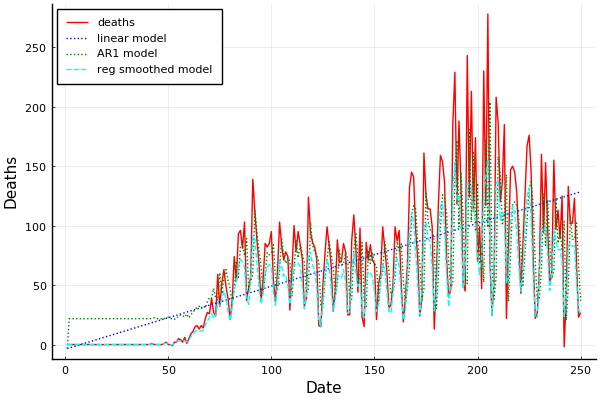

In [23]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_smooth_reg, color=:cyan, linestyle=:dash, label="reg smoothed model")
xlabel!("Date")
ylabel!("Deaths")